In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

### A4.25


In [ ]:

P = cp.Variable((2, 2, 2, 2), nonneg=True)

prob_X1_1 = 0.9
prob_X2_1 = 0.9
prob_X3_1 = 0.1

prob_X1_1_X4_0_given_X3_1 = 0.7
prob_X4_1_given_X2_1_X3_0 = 0.6


constraints = []
constraints.append(cp.sum(P) == 1)

constraints.append(cp.sum(P[1, :, :, :]) == prob_X1_1) 
constraints.append(cp.sum(P[:, 1, :, :]) == prob_X2_1)  
constraints.append(cp.sum(P[:, :, 1, :]) == prob_X3_1) 

constraints.append(cp.sum(P[1, :, 1, 0]) == prob_X1_1_X4_0_given_X3_1 * prob_X3_1) 
constraints.append(cp.sum(P[:, 1, 0, 1]) == prob_X4_1_given_X2_1_X3_0*cp.sum(P[:, 1, 0, :]))  

prob_X4_1 = cp.sum(P[:, :, :, 1]) 


In [22]:
# Min
objective_min = cp.Minimize(prob_X4_1)
prob_min = cp.Problem(objective_min, constraints)
min_X4_1 = prob_min.solve()

# Max
objective_max = cp.Maximize(prob_X4_1)
prob_max = cp.Problem(objective_max, constraints)
max_X4_1 = prob_max.solve()


print(f"Minimum possible value of P(X4=1): {min_X4_1}")
print(f"Maximum possible value of P(X4=1): {max_X4_1}")


Minimum possible value of P(X4=1): 0.4799999999984676
Maximum possible value of P(X4=1): 0.6100000000407152


### A6.2


In [9]:
k = 201
t_vals = np.zeros(k)
y_vals = np.zeros(k)
for i in range(k):
    t_vals[i] = -3 + 6*(i)/(k-1)
    y_vals[i] = np.exp(t_vals[i])

In [11]:

k = 201
t = np.linspace(-3, 3, k)
y = np.exp(t)
eps = 1e-20


z_low = 0        
z_high = 0.5         
tolerance = 1e-3     
max_iter = 10000       


a_opt = None
b_opt = None
optimal_z = None


for _ in range(max_iter):
    z_mid = (z_low + z_high) / 2
    
    a = cp.Variable(3)
    b = cp.Variable(2)
    numerator = a[0] + a[1]*t + a[2]*t**2
    denominator = 1 + b[0]*t + b[1]*t**2
    
    constraints = [
        denominator >= eps,
        numerator <= cp.multiply(y + z_mid,denominator),
        numerator >= cp.multiply(y - z_mid,denominator)
    ]
    
    prob = cp.Problem(cp.Minimize(0), constraints)
    try:
        prob.solve()
        if prob.status == 'optimal':
            z_high = z_mid
            a_opt = a.value
            b_opt = b.value
            optimal_z = z_mid
        else:
            z_low = z_mid
    except:
        z_low = z_mid
    
    if z_high - z_low < tolerance:
        break



Optimal a: [1.00971841 0.61231693 0.11368177]
Optimal b: [-0.41434627  0.04843342]
Optimal maximum error: 0.023


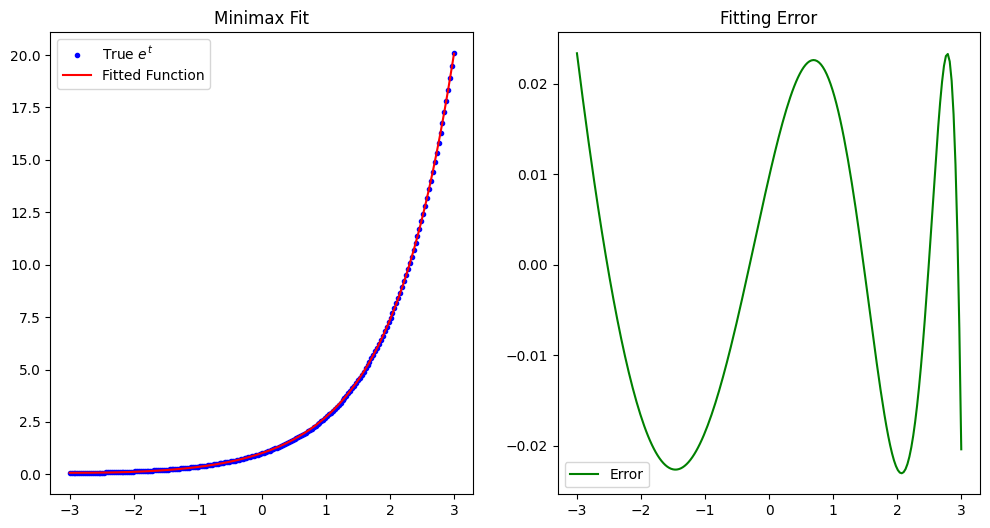

In [12]:
# Results
print(f"Optimal a: {a_opt}")
print(f"Optimal b: {b_opt}")
print(f"Optimal maximum error: {optimal_z:.3f}")

# Plotting
f_opt = (a_opt[0] + a_opt[1]*t + a_opt[2]*t**2) / (1 + b_opt[0]*t + b_opt[1]*t**2)
error = f_opt - y

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, y, 'b.', label='True $e^t$')
plt.plot(t, f_opt, 'r-', label='Fitted Function')
plt.legend()
plt.title('Minimax Fit')

plt.subplot(1, 2, 2)
plt.plot(t, error, 'g-', label='Error')
plt.legend()
plt.title('Fitting Error')
plt.show()

### A6.19

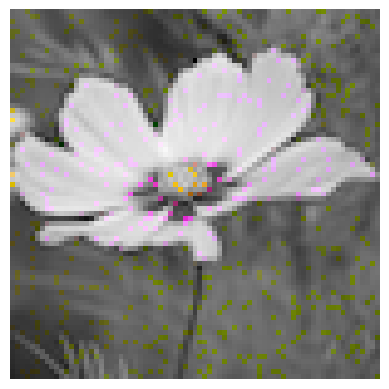

In [ ]:


img = mpimg.imread("flower.png")
img = img[:,:,0:3]
m,n,_ = img.shape

np.random.seed(5)
random_numbers = np.random.rand(m,n)
known_ind = np.where(random_numbers >= 0.90)

# Very important as of 2025. Without this the solvers 
# declare the problem as primal infeasible due to numerics.
img = img.astype('float64')

# grayscale image
M = 0.299*img[:,:,0]+0.587*img[:,:,1]+0.114*img[:,:,2]
# known color values
R_known = img[:,:,0]
G_known = img[:,:,1]
B_known = img[:,:,2]
R_known = R_known[known_ind]
G_known = G_known[known_ind]
B_known = B_known[known_ind]

def save_img(filename, R,G,B):
   img = np.stack((np.array(R),np.array(G),np.array(B)), axis=2)
   plt.imshow(img)
   plt.axis('off')  # Turn off axis labels and ticks
   plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Remove x-axis ticks
   plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Remove y-axis ticks
    
   plt.savefig(filename, bbox_inches='tight', pad_inches=0)

R_given = np.copy(M)
R_given[known_ind] = R_known
G_given = np.copy(M)
G_given[known_ind] = G_known
B_given = np.copy(M)
B_given[known_ind] = B_known
save_img("flower_2025_given.png", R_given, G_given, B_given)

In [157]:


m, n = M.shape
R = cp.Variable((m, n))
G = cp.Variable((m, n))
B = cp.Variable((m, n))

constraints = [0.299 * R + 0.587 * G + 0.114 * B == M]

for (i, j), r_val, g_val, b_val in zip(zip(known_ind[0], known_ind[1]), R_known, G_known, B_known):
    constraints.append(R[i, j] == r_val)
    constraints.append(G[i, j] == g_val)
    constraints.append(B[i, j] == b_val)

constraints.append(0 <= R)
constraints.append(R <= 1)
constraints.append(0 <= G)
constraints.append(G <= 1)
constraints.append(0 <= B)
constraints.append(B <= 1)


tv = cp.tv(R, G, B)



In [158]:

objective = cp.Minimize(tv)
problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(620.7815751648797)

Optimal objective value: 620.7816


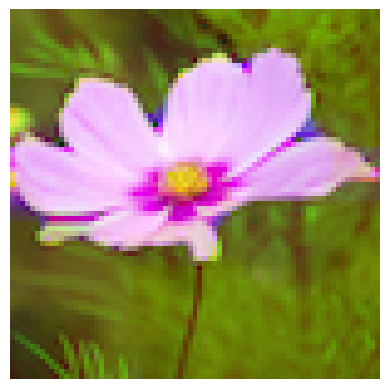

In [159]:

save_img("flower_colorized_2025.png", R_opt, G_opt, B_opt)

print(f"Optimal objective value: {problem.value:.4f}")


### A7.6(b)


In [2]:

np.random.seed(1)
N = 100

# create an increasing input signal
xtrue = np.zeros(N)
xtrue[0:40] = 0.1
xtrue[49] = 2
xtrue[69:80] = 0.15
xtrue[79] = 1
xtrue = np.cumsum(xtrue)

# pass the increasing input through a moving-average filter
# and add Gaussian noise
h = np.array([1, -0.85, 0.7, -0.3])
k = h.size
yhat = np.convolve(h, xtrue)
y = yhat[0:-3] + np.random.randn(N)

In [3]:

H = np.zeros((N, N))
for i in range(N):
    for j in range(k):
        if i - j >= 0:
            H[i, i - j] = h[j]

x = cp.Variable(N)
objective = cp.Minimize(cp.sum_squares(H @ x - y))

constraints = [x >= 0]  
constraints += [x[i + 1] >= x[i] for i in range(N - 1)] 


In [4]:

problem = cp.Problem(objective, constraints)
problem.solve()
x_ml = x.value
 

In [5]:
x_free = cp.Variable(N)
problem_free = cp.Problem(cp.Minimize(cp.sum_squares(y - H @ x_free)))
problem_free.solve()
x_ml_free = x_free.value

In [7]:
problem.value

57.61398214011427

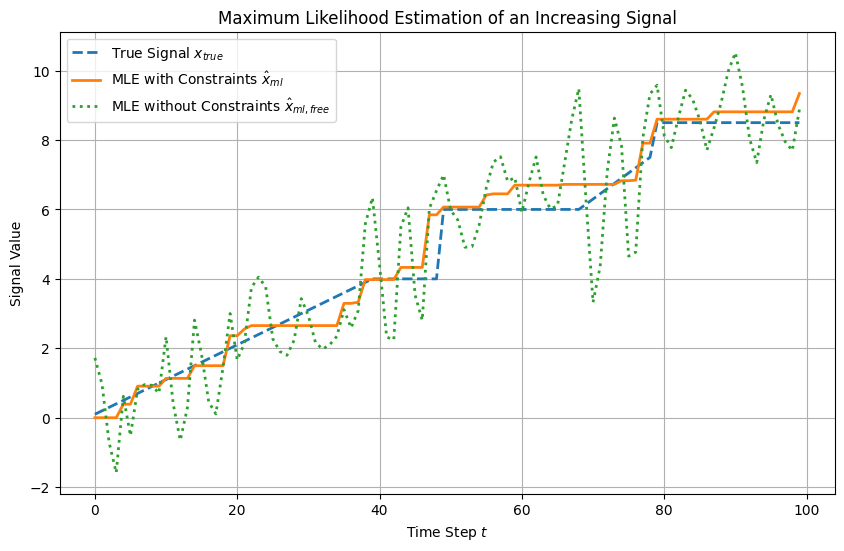

Objective Value (With Constraints): 57.6140
Objective Value (Without Constraints): 0.0000


In [6]:

plt.figure(figsize=(10, 6))
plt.plot(xtrue, label="True Signal $x_{true}$", linestyle="dashed", linewidth=2)
plt.plot(x_ml, label="MLE with Constraints $\\hat{x}_{ml}$", linewidth=2)
plt.plot(x_ml_free, label="MLE without Constraints $\\hat{x}_{ml,free}$", linewidth=2, linestyle="dotted")
plt.xlabel("Time Step $t$")
plt.ylabel("Signal Value")
plt.legend()
plt.title("Maximum Likelihood Estimation of an Increasing Signal")
plt.grid()
plt.show()

# Display objective values
ml_objective = cp.norm(H @ x_ml - y, p =2) ** 2
free_objective = cp.norm(H @ x_ml_free - y, p=2) ** 2

ml_objective_value = ml_objective.value
free_objective_value = free_objective.value

print(f"Objective Value (With Constraints): {ml_objective_value:.4f}")
print(f"Objective Value (Without Constraints): {free_objective_value:.4f}")


### A15.13 (b)

In [182]:
# data for problem on bandlimited signal recovery from zero crossings
n = 2048
f_min = 4
B = 9
s = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]).T
y = np.array([-1.0094, -0.9767, -0.9433, -0.9090, -0.8740, -0.8383, -0.8019, -0.7648, -0.7271, -0.6888, -0.6499, -0.6105, -0.5706, -0.5303, -0.4896, -0.4484, -0.4070, -0.3652, -0.3232, -0.2810, -0.2386, -0.1960, -0.1534, -0.1107, -0.0680, -0.0252, 0.0174, 0.0600, 0.1024, 0.1446, 0.1867, 0.2285, 0.2699, 0.3111, 0.3518, 0.3922, 0.4321, 0.4715, 0.5105, 0.5488, 0.5865, 0.6237, 0.6601, 0.6959, 0.7309, 0.7652, 0.7986, 0.8312, 0.8630, 0.8939, 0.9238, 0.9528, 0.9809, 1.0079, 1.0339, 1.0588, 1.0827, 1.1055, 1.1271, 1.1477, 1.1670, 1.1852, 1.2022, 1.2179, 1.2325, 1.2458, 1.2578, 1.2686, 1.2781, 1.2863, 1.2933, 1.2989, 1.3032, 1.3062, 1.3079, 1.3083, 1.3074, 1.3051, 1.3016, 1.2967, 1.2905, 1.2830, 1.2743, 1.2642, 1.2528, 1.2402, 1.2264, 1.2112, 1.1949, 1.1773, 1.1586, 1.1386, 1.1175, 1.0952, 1.0718, 1.0473, 1.0218, 0.9951, 0.9674, 0.9387, 0.9091, 0.8784, 0.8469, 0.8144, 0.7811, 0.7469, 0.7119, 0.6761, 0.6396, 0.6024, 0.5644, 0.5259, 0.4867, 0.4470, 0.4067, 0.3659, 0.3246, 0.2829, 0.2409, 0.1984, 0.1557, 0.1127, 0.0694, 0.0259, -0.0177, -0.0614, -0.1053, -0.1491, -0.1930, -0.2368, -0.2806, -0.3242, -0.3677, -0.4110, -0.4540, -0.4968, -0.5393, -0.5814, -0.6232, -0.6645, -0.7053, -0.7457, -0.7856, -0.8248, -0.8635, -0.9015, -0.9389, -0.9756, -1.0115, -1.0467, -1.0810, -1.1146, -1.1473, -1.1791, -1.2100, -1.2399, -1.2689, -1.2969, -1.3239, -1.3499, -1.3747, -1.3985, -1.4213, -1.4428, -1.4633, -1.4826, -1.5007, -1.5176, -1.5333, -1.5479, -1.5611, -1.5732, -1.5840, -1.5935, -1.6018, -1.6088, -1.6146, -1.6190, -1.6222, -1.6241, -1.6247, -1.6240, -1.6220, -1.6188, -1.6143, -1.6085, -1.6014, -1.5931, -1.5835, -1.5727, -1.5607, -1.5474, -1.5329, -1.5172, -1.5004, -1.4824, -1.4632, -1.4429, -1.4215, -1.3990, -1.3754, -1.3507, -1.3251, -1.2984, -1.2707, -1.2420, -1.2124, -1.1819, -1.1506, -1.1183, -1.0852, -1.0513, -1.0166, -0.9812, -0.9451, -0.9082, -0.8707, -0.8326, -0.7939, -0.7546, -0.7148, -0.6744, -0.6336, -0.5924, -0.5507, -0.5087, -0.4664, -0.4237, -0.3808, -0.3376, -0.2943, -0.2507, -0.2071, -0.1633, -0.1195, -0.0756, -0.0317, 0.0121, 0.0559, 0.0996, 0.1432, 0.1866, 0.2298, 0.2728, 0.3155, 0.3580, 0.4001, 0.4419, 0.4834, 0.5244, 0.5650, 0.6051, 0.6448, 0.6840, 0.7226, 0.7606, 0.7981, 0.8350, 0.8712, 0.9068, 0.9417, 0.9759, 1.0094, 1.0422, 1.0742, 1.1055, 1.1359, 1.1656, 1.1944, 1.2224, 1.2495, 1.2758, 1.3012, 1.3257, 1.3494, 1.3721, 1.3939, 1.4148, 1.4348, 1.4538, 1.4719, 1.4891, 1.5053, 1.5205, 1.5348, 1.5482, 1.5605, 1.5720, 1.5825, 1.5920, 1.6006, 1.6082, 1.6149, 1.6207, 1.6255, 1.6294, 1.6324, 1.6345, 1.6357, 1.6360, 1.6354, 1.6339, 1.6316, 1.6285, 1.6245, 1.6196, 1.6140, 1.6076, 1.6003, 1.5924, 1.5836, 1.5741, 1.5639, 1.5530, 1.5414, 1.5292, 1.5163, 1.5027, 1.4885, 1.4737, 1.4584, 1.4425, 1.4260, 1.4090, 1.3915, 1.3735, 1.3550, 1.3361, 1.3167, 1.2970, 1.2768, 1.2563, 1.2354, 1.2142, 1.1927, 1.1708, 1.1487, 1.1263, 1.1037, 1.0809, 1.0579, 1.0346, 1.0113, 0.9877, 0.9640, 0.9403, 0.9164, 0.8924, 0.8684, 0.8443, 0.8202, 0.7960, 0.7719, 0.7478, 0.7237, 0.6996, 0.6756, 0.6517, 0.6278, 0.6041, 0.5804, 0.5569, 0.5334, 0.5101, 0.4870, 0.4640, 0.4412, 0.4186, 0.3961, 0.3738, 0.3518, 0.3299, 0.3083, 0.2868, 0.2656, 0.2447, 0.2239, 0.2034, 0.1832, 0.1632, 0.1434, 0.1240, 0.1047, 0.0857, 0.0670, 0.0486, 0.0304, 0.0125, -0.0052, -0.0225, -0.0397, -0.0565, -0.0731, -0.0894, -0.1055, -0.1213, -0.1368, -0.1521, -0.1671, -0.1819, -0.1964, -0.2106, -0.2247, -0.2384, -0.2520, -0.2653, -0.2784, -0.2912, -0.3038, -0.3162, -0.3284, -0.3404, -0.3521, -0.3637, -0.3750, -0.3861, -0.3971, -0.4079, -0.4184, -0.4288, -0.4390, -0.4491, -0.4590, -0.4687, -0.4782, -0.4876, -0.4968, -0.5058, -0.5148, -0.5235, -0.5321, -0.5406, -0.5489, -0.5571, -0.5652, -0.5731, -0.5809, -0.5886, -0.5961, -0.6035, -0.6108, -0.6179, -0.6249, -0.6318, -0.6386, -0.6452, -0.6518, -0.6582, -0.6644, -0.6706, -0.6766, -0.6825, -0.6882, -0.6938, -0.6993, -0.7047, -0.7099, -0.7149, -0.7199, -0.7247, -0.7293, -0.7338, -0.7381, -0.7423, -0.7463, -0.7502, -0.7539, -0.7574, -0.7608, -0.7640, -0.7670, -0.7698, -0.7724, -0.7748, -0.7771, -0.7791, -0.7810, -0.7826, -0.7840, -0.7853, -0.7863, -0.7870, -0.7876, -0.7879, -0.7880, -0.7879, -0.7875, -0.7869, -0.7860, -0.7849, -0.7836, -0.7820, -0.7801, -0.7780, -0.7757, -0.7730, -0.7702, -0.7670, -0.7636, -0.7600, -0.7560, -0.7518, -0.7474, -0.7427, -0.7377, -0.7324, -0.7269, -0.7212, -0.7151, -0.7089, -0.7023, -0.6956, -0.6885, -0.6813, -0.6738, -0.6660, -0.6581, -0.6499, -0.6414, -0.6328, -0.6240, -0.6149, -0.6057, -0.5962, -0.5866, -0.5768, -0.5668, -0.5566, -0.5463, -0.5359, -0.5253, -0.5146, -0.5038, -0.4928, -0.4818, -0.4706, -0.4594, -0.4481, -0.4368, -0.4254, -0.4139, -0.4025, -0.3910, -0.3795, -0.3680, -0.3565, -0.3451, -0.3337, -0.3224, -0.3111, -0.2999, -0.2888, -0.2777, -0.2668, -0.2560, -0.2454, -0.2349, -0.2245, -0.2144, -0.2044, -0.1946, -0.1850, -0.1756, -0.1664, -0.1575, -0.1489, -0.1404, -0.1323, -0.1244, -0.1168, -0.1095, -0.1026, -0.0959, -0.0895, -0.0835, -0.0778, -0.0725, -0.0675, -0.0628, -0.0585, -0.0546, -0.0511, -0.0479, -0.0451, -0.0427, -0.0406, -0.0390, -0.0377, -0.0369, -0.0364, -0.0363, -0.0366, -0.0373, -0.0384, -0.0399, -0.0417, -0.0439, -0.0466, -0.0495, -0.0529, -0.0566, -0.0606, -0.0651, -0.0698, -0.0749, -0.0803, -0.0860, -0.0920, -0.0984, -0.1050, -0.1118, -0.1190, -0.1264, -0.1340, -0.1419, -0.1499, -0.1582, -0.1666, -0.1752, -0.1840, -0.1929, -0.2019, -0.2110, -0.2202, -0.2294, -0.2387, -0.2481, -0.2574, -0.2668, -0.2761, -0.2853, -0.2945, -0.3037, -0.3127, -0.3216, -0.3303, -0.3389, -0.3473, -0.3555, -0.3635, -0.3712, -0.3787, -0.3858, -0.3927, -0.3993, -0.4055, -0.4113, -0.4168, -0.4219, -0.4265, -0.4307, -0.4345, -0.4377, -0.4405, -0.4428, -0.4446, -0.4458, -0.4464, -0.4465, -0.4460, -0.4449, -0.4432, -0.4408, -0.4379, -0.4342, -0.4299, -0.4250, -0.4193, -0.4130, -0.4059, -0.3982, -0.3897, -0.3806, -0.3707, -0.3600, -0.3487, -0.3366, -0.3238, -0.3102, -0.2959, -0.2809, -0.2651, -0.2486, -0.2314, -0.2134, -0.1948, -0.1754, -0.1554, -0.1346, -0.1132, -0.0910, -0.0683, -0.0449, -0.0208, 0.0039, 0.0292, 0.0550, 0.0815, 0.1085, 0.1360, 0.1641, 0.1926, 0.2217, 0.2512, 0.2811, 0.3114, 0.3421, 0.3732, 0.4045, 0.4362, 0.4682, 0.5004, 0.5329, 0.5655, 0.5983, 0.6312, 0.6643, 0.6973, 0.7305, 0.7636, 0.7967, 0.8298, 0.8627, 0.8955, 0.9282, 0.9607, 0.9929, 1.0248, 1.0565, 1.0878, 1.1188, 1.1494, 1.1795, 1.2091, 1.2382, 1.2668, 1.2948, 1.3222, 1.3490, 1.3751, 1.4004, 1.4251, 1.4489, 1.4719, 1.4941, 1.5154, 1.5359, 1.5553, 1.5739, 1.5914, 1.6079, 1.6234, 1.6378, 1.6512, 1.6634, 1.6744, 1.6843, 1.6931, 1.7006, 1.7069, 1.7119, 1.7157, 1.7182, 1.7194, 1.7193, 1.7179, 1.7152, 1.7111, 1.7057, 1.6989, 1.6908, 1.6813, 1.6704, 1.6582, 1.6446, 1.6296, 1.6132, 1.5955, 1.5764, 1.5559, 1.5341, 1.5110, 1.4865, 1.4607, 1.4336, 1.4052, 1.3755, 1.3446, 1.3124, 1.2790, 1.2444, 1.2086, 1.1717, 1.1336, 1.0945, 1.0542, 1.0129, 0.9706, 0.9273, 0.8830, 0.8379, 0.7918, 0.7449, 0.6972, 0.6487, 0.5995, 0.5496, 0.4990, 0.4478, 0.3960, 0.3438, 0.2910, 0.2378, 0.1842, 0.1303, 0.0760, 0.0215, -0.0331, -0.0880, -0.1429, -0.1979, -0.2529, -0.3079, -0.3628, -0.4175, -0.4720, -0.5263, -0.5803, -0.6339, -0.6872, -0.7400, -0.7923, -0.8440, -0.8952, -0.9457, -0.9955, -1.0445, -1.0928, -1.1402, -1.1868, -1.2324, -1.2770, -1.3206, -1.3631, -1.4046, -1.4448, -1.4839, -1.5218, -1.5583, -1.5936, -1.6275, -1.6600, -1.6911, -1.7207, -1.7489, -1.7755, -1.8006, -1.8241, -1.8460, -1.8663, -1.8849, -1.9019, -1.9171, -1.9307, -1.9425, -1.9525, -1.9608, -1.9673, -1.9720, -1.9749, -1.9761, -1.9754, -1.9728, -1.9685, -1.9623, -1.9544, -1.9446, -1.9330, -1.9195, -1.9043, -1.8873, -1.8685, -1.8480, -1.8257, -1.8016, -1.7759, -1.7485, -1.7193, -1.6886, -1.6562, -1.6222, -1.5866, -1.5495, -1.5109, -1.4708, -1.4293, -1.3864, -1.3420, -1.2964, -1.2495, -1.2013, -1.1519, -1.1014, -1.0497, -0.9970, -0.9433, -0.8886, -0.8329, -0.7764, -0.7191, -0.6610, -0.6021, -0.5427, -0.4826, -0.4219, -0.3608, -0.2992, -0.2373, -0.1750, -0.1124, -0.0497, 0.0132, 0.0762, 0.1392, 0.2022, 0.2651, 0.3279, 0.3904, 0.4527, 0.5146, 0.5762, 0.6373, 0.6980, 0.7580, 0.8175, 0.8763, 0.9343, 0.9916, 1.0481, 1.1036, 1.1582, 1.2118, 1.2644, 1.3158, 1.3661, 1.4152, 1.4631, 1.5097, 1.5549, 1.5988, 1.6413, 1.6823, 1.7217, 1.7597, 1.7961, 1.8308, 1.8640, 1.8954, 1.9252, 1.9532, 1.9794, 2.0039, 2.0265, 2.0473, 2.0663, 2.0834, 2.0986, 2.1119, 2.1233, 2.1328, 2.1403, 2.1459, 2.1495, 2.1512, 2.1509, 2.1486, 2.1445, 2.1383, 2.1302, 2.1202, 2.1083, 2.0944, 2.0787, 2.0610, 2.0415, 2.0201, 1.9969, 1.9719, 1.9450, 1.9165, 1.8862, 1.8541, 1.8204, 1.7851, 1.7481, 1.7096, 1.6695, 1.6279, 1.5849, 1.5404, 1.4945, 1.4473, 1.3988, 1.3491, 1.2981, 1.2460, 1.1928, 1.1385, 1.0832, 1.0269, 0.9698, 0.9117, 0.8529, 0.7933, 0.7331, 0.6721, 0.6107, 0.5486, 0.4861, 0.4232, 0.3600, 0.2964, 0.2326, 0.1686, 0.1045, 0.0403, -0.0239, -0.0880, -0.1521, -0.2160, -0.2797, -0.3431, -0.4062, -0.4689, -0.5312, -0.5930, -0.6542, -0.7149, -0.7749, -0.8342, -0.8928, -0.9506, -1.0075, -1.0636, -1.1187, -1.1728, -1.2259, -1.2780, -1.3289, -1.3787, -1.4273, -1.4746, -1.5207, -1.5655, -1.6090, -1.6511, -1.6918, -1.7311, -1.7689, -1.8053, -1.8401, -1.8734, -1.9052, -1.9354, -1.9641, -1.9911, -2.0165, -2.0402, -2.0624, -2.0828, -2.1017, -2.1188, -2.1343, -2.1481, -2.1602, -2.1706, -2.1794, -2.1864, -2.1918, -2.1956, -2.1977, -2.1981, -2.1969, -2.1941, -2.1896, -2.1836, -2.1760, -2.1668, -2.1561, -2.1439, -2.1302, -2.1150, -2.0983, -2.0802, -2.0608, -2.0399, -2.0177, -1.9942, -1.9695, -1.9435, -1.9163, -1.8879, -1.8583, -1.8277, -1.7960, -1.7633, -1.7296, -1.6949, -1.6593, -1.6229, -1.5856, -1.5475, -1.5087, -1.4692, -1.4290, -1.3882, -1.3468, -1.3049, -1.2625, -1.2196, -1.1763, -1.1327, -1.0888, -1.0445, -1.0001, -0.9554, -0.9106, -0.8657, -0.8207, -0.7758, -0.7308, -0.6858, -0.6410, -0.5963, -0.5518, -0.5075, -0.4634, -0.4197, -0.3762, -0.3331, -0.2904, -0.2481, -0.2063, -0.1650, -0.1241, -0.0839, -0.0442, -0.0051, 0.0334, 0.0712, 0.1084, 0.1448, 0.1805, 0.2155, 0.2497, 0.2831, 0.3158, 0.3476, 0.3785, 0.4087, 0.4379, 0.4663, 0.4939, 0.5205, 0.5462, 0.5711, 0.5950, 0.6180, 0.6401, 0.6613, 0.6816, 0.7009, 0.7194, 0.7369, 0.7535, 0.7692, 0.7840, 0.7980, 0.8110, 0.8232, 0.8345, 0.8449, 0.8545, 0.8633, 0.8713, 0.8785, 0.8848, 0.8905, 0.8953, 0.8995, 0.9029, 0.9056, 0.9077, 0.9091, 0.9098, 0.9100, 0.9095, 0.9085, 0.9070, 0.9049, 0.9023, 0.8993, 0.8957, 0.8918, 0.8875, 0.8828, 0.8777, 0.8723, 0.8666, 0.8606, 0.8543, 0.8479, 0.8412, 0.8343, 0.8273, 0.8201, 0.8128, 0.8054, 0.7980, 0.7905, 0.7830, 0.7755, 0.7680, 0.7606, 0.7532, 0.7459, 0.7387, 0.7316, 0.7246, 0.7178, 0.7111, 0.7047, 0.6984, 0.6923, 0.6865, 0.6809, 0.6755, 0.6704, 0.6656, 0.6610, 0.6567, 0.6528, 0.6491, 0.6457, 0.6426, 0.6398, 0.6374, 0.6352, 0.6334, 0.6319, 0.6307, 0.6298, 0.6293, 0.6290, 0.6290, 0.6294, 0.6300, 0.6309, 0.6321, 0.6335, 0.6352, 0.6372, 0.6394, 0.6418, 0.6444, 0.6472, 0.6502, 0.6534, 0.6567, 0.6601, 0.6637, 0.6674, 0.6712, 0.6750, 0.6789, 0.6828, 0.6867, 0.6906, 0.6945, 0.6983, 0.7021, 0.7057, 0.7093, 0.7127, 0.7160, 0.7191, 0.7219, 0.7246, 0.7270, 0.7292, 0.7311, 0.7326, 0.7339, 0.7347, 0.7353, 0.7354, 0.7351, 0.7344, 0.7332, 0.7316, 0.7295, 0.7268, 0.7237, 0.7200, 0.7157, 0.7109, 0.7055, 0.6995, 0.6928, 0.6856, 0.6777, 0.6691, 0.6599, 0.6500, 0.6394, 0.6282, 0.6162, 0.6035, 0.5901, 0.5760, 0.5612, 0.5457, 0.5295, 0.5125, 0.4948, 0.4764, 0.4573, 0.4374, 0.4169, 0.3957, 0.3737, 0.3511, 0.3278, 0.3039, 0.2793, 0.2540, 0.2282, 0.2017, 0.1746, 0.1470, 0.1187, 0.0900, 0.0607, 0.0309, 0.0007, -0.0300, -0.0612, -0.0927, -0.1246, -0.1569, -0.1895, -0.2224, -0.2556, -0.2890, -0.3226, -0.3564, -0.3903, -0.4244, -0.4585, -0.4927, -0.5269, -0.5611, -0.5952, -0.6292, -0.6631, -0.6968, -0.7303, -0.7636, -0.7965, -0.8292, -0.8615, -0.8935, -0.9250, -0.9560, -0.9865, -1.0165, -1.0460, -1.0748, -1.1029, -1.1304, -1.1571, -1.1831, -1.2083, -1.2326, -1.2561, -1.2787, -1.3003, -1.3210, -1.3407, -1.3593, -1.3769, -1.3934, -1.4088, -1.4231, -1.4361, -1.4480, -1.4586, -1.4680, -1.4761, -1.4830, -1.4885, -1.4926, -1.4955, -1.4969, -1.4970, -1.4956, -1.4929, -1.4887, -1.4831, -1.4760, -1.4675, -1.4576, -1.4461, -1.4332, -1.4188, -1.4030, -1.3857, -1.3669, -1.3467, -1.3250, -1.3018, -1.2773, -1.2512, -1.2238, -1.1950, -1.1647, -1.1331, -1.1002, -1.0659, -1.0303, -0.9934, -0.9552, -0.9158, -0.8752, -0.8334, -0.7905, -0.7464, -0.7012, -0.6550, -0.6077, -0.5594, -0.5102, -0.4601, -0.4092, -0.3573, -0.3048, -0.2514, -0.1974, -0.1427, -0.0874, -0.0315, 0.0248, 0.0816, 0.1389, 0.1965, 0.2544, 0.3125, 0.3709, 0.4294, 0.4880, 0.5466, 0.6053, 0.6638, 0.7223, 0.7805, 0.8386, 0.8963, 0.9537, 1.0107, 1.0672, 1.1233, 1.1787, 1.2335, 1.2877, 1.3411, 1.3937, 1.4455, 1.4964, 1.5464, 1.5953, 1.6432, 1.6900, 1.7356, 1.7800, 1.8232, 1.8651, 1.9056, 1.9447, 1.9825, 2.0187, 2.0534, 2.0865, 2.1181, 2.1480, 2.1762, 2.2027, 2.2275, 2.2504, 2.2716, 2.2910, 2.3084, 2.3240, 2.3376, 2.3493, 2.3591, 2.3668, 2.3726, 2.3763, 2.3780, 2.3777, 2.3752, 2.3708, 2.3642, 2.3556, 2.3449, 2.3321, 2.3172, 2.3003, 2.2813, 2.2602, 2.2370, 2.2118, 2.1846, 2.1553, 2.1240, 2.0907, 2.0555, 2.0183, 1.9792, 1.9381, 1.8952, 1.8505, 1.8039, 1.7556, 1.7055, 1.6536, 1.6002, 1.5450, 1.4883, 1.4300, 1.3702, 1.3090, 1.2463, 1.1822, 1.1169, 1.0502, 0.9823, 0.9133, 0.8432, 0.7720, 0.6998, 0.6266, 0.5526, 0.4777, 0.4021, 0.3258, 0.2488, 0.1713, 0.0932, 0.0147, -0.0642, -0.1434, -0.2229, -0.3025, -0.3823, -0.4621, -0.5420, -0.6217, -0.7014, -0.7808, -0.8599, -0.9387, -1.0171, -1.0950, -1.1724, -1.2492, -1.3253, -1.4006, -1.4752, -1.5489, -1.6217, -1.6935, -1.7643, -1.8340, -1.9025, -1.9697, -2.0357, -2.1004, -2.1637, -2.2255, -2.2858, -2.3446, -2.4018, -2.4573, -2.5112, -2.5633, -2.6136, -2.6621, -2.7087, -2.7535, -2.7962, -2.8370, -2.8758, -2.9125, -2.9472, -2.9797, -3.0101, -3.0384, -3.0645, -3.0883, -3.1099, -3.1293, -3.1464, -3.1613, -3.1739, -3.1841, -3.1921, -3.1977, -3.2011, -3.2021, -3.2008, -3.1972, -3.1912, -3.1830, -3.1725, -3.1597, -3.1446, -3.1272, -3.1076, -3.0858, -3.0618, -3.0355, -3.0072, -2.9766, -2.9440, -2.9093, -2.8725, -2.8337, -2.7930, -2.7502, -2.7056, -2.6591, -2.6108, -2.5606, -2.5087, -2.4552, -2.3999, -2.3431, -2.2847, -2.2247, -2.1633, -2.1006, -2.0364, -1.9710, -1.9043, -1.8364, -1.7674, -1.6973, -1.6263, -1.5542, -1.4813, -1.4075, -1.3330, -1.2578, -1.1819, -1.1054, -1.0285, -0.9510, -0.8732, -0.7951, -0.7167, -0.6381, -0.5593, -0.4805, -0.4017, -0.3230, -0.2444, -0.1659, -0.0877, -0.0098, 0.0677, 0.1448, 0.2214, 0.2974, 0.3728, 0.4476, 0.5216, 0.5948, 0.6672, 0.7387, 0.8092, 0.8788, 0.9472, 1.0146, 1.0808, 1.1458, 1.2095, 1.2720, 1.3331, 1.3928, 1.4511, 1.5079, 1.5632, 1.6169, 1.6691, 1.7197, 1.7686, 1.8158, 1.8613, 1.9051, 1.9471, 1.9873, 2.0257, 2.0623, 2.0970, 2.1299, 2.1608, 2.1899, 2.2171, 2.2423, 2.2656, 2.2870, 2.3064, 2.3239, 2.3394, 2.3530, 2.3646, 2.3743, 2.3820, 2.3878, 2.3917, 2.3937, 2.3938, 2.3920, 2.3884, 2.3828, 2.3755, 2.3663, 2.3554, 2.3427, 2.3282, 2.3120, 2.2942, 2.2746, 2.2535, 2.2307, 2.2064, 2.1806, 2.1532, 2.1244, 2.0942, 2.0627, 2.0297, 1.9955, 1.9600, 1.9233, 1.8855, 1.8465, 1.8064, 1.7653, 1.7233, 1.6803, 1.6364, 1.5916, 1.5461, 1.4998, 1.4529, 1.4053, 1.3571, 1.3084, 1.2591, 1.2095, 1.1595, 1.1091, 1.0585, 1.0076, 0.9566, 0.9054, 0.8542, 0.8029, 0.7517, 0.7005, 0.6495, 0.5986, 0.5480, 0.4977, 0.4476, 0.3980, 0.3487, 0.3000, 0.2517, 0.2040, 0.1568, 0.1103, 0.0645, 0.0194, -0.0249, -0.0684, -0.1111, -0.1529, -0.1938, -0.2338, -0.2728, -0.3108, -0.3477, -0.3836, -0.4184, -0.4520, -0.4845, -0.5159, -0.5460, -0.5749, -0.6026, -0.6290, -0.6541, -0.6779, -0.7005, -0.7217, -0.7416, -0.7601, -0.7773, -0.7931, -0.8076, -0.8207, -0.8324, -0.8427, -0.8517, -0.8593, -0.8655, -0.8703, -0.8738, -0.8760, -0.8768, -0.8762, -0.8744, -0.8712, -0.8667, -0.8610, -0.8539, -0.8456, -0.8361, -0.8254, -0.8135, -0.8004, -0.7862, -0.7709, -0.7544, -0.7370, -0.7184, -0.6989, -0.6784, -0.6569, -0.6345, -0.6112, -0.5871, -0.5621, -0.5364, -0.5100, -0.4828, -0.4549, -0.4264, -0.3973, -0.3677, -0.3375, -0.3068, -0.2757, -0.2442, -0.2124, -0.1802, -0.1477, -0.1150, -0.0821, -0.0491, -0.0159, 0.0174, 0.0507, 0.0839, 0.1172, 0.1503, 0.1833, 0.2162, 0.2488, 0.2812, 0.3133, 0.3450, 0.3764, 0.4074, 0.4380, 0.4680, 0.4976, 0.5266, 0.5550, 0.5828, 0.6100, 0.6364, 0.6622, 0.6872, 0.7114, 0.7348, 0.7573, 0.7790, 0.7998, 0.8197, 0.8387, 0.8567, 0.8737, 0.8897, 0.9046, 0.9185, 0.9314, 0.9432, 0.9538, 0.9634, 0.9718, 0.9791, 0.9853, 0.9902, 0.9941, 0.9967, 0.9982, 0.9985, 0.9976, 0.9955, 0.9922, 0.9878, 0.9821, 0.9753, 0.9673, 0.9581, 0.9478, 0.9363, 0.9236, 0.9099, 0.8950, 0.8789, 0.8618, 0.8436, 0.8243, 0.8040, 0.7827, 0.7603, 0.7370, 0.7126, 0.6874, 0.6612, 0.6341, 0.6062, 0.5774, 0.5478, 0.5173, 0.4862, 0.4543, 0.4217, 0.3885, 0.3546, 0.3201, 0.2850, 0.2494, 0.2133, 0.1768, 0.1398, 0.1024, 0.0647, 0.0267, -0.0117, -0.0502, -0.0890, -0.1279, -0.1670, -0.2062, -0.2454, -0.2846, -0.3238, -0.3629, -0.4019, -0.4408, -0.4795, -0.5179, -0.5562, -0.5941, -0.6316, -0.6688, -0.7056, -0.7420, -0.7778, -0.8132, -0.8480, -0.8822, -0.9157, -0.9486, -0.9809, -1.0123, -1.0431, -1.0730, -1.1022, -1.1304, -1.1578, -1.1843, -1.2099, -1.2345, -1.2581, -1.2808, -1.3023, -1.3229, -1.3423, -1.3607, -1.3779, -1.3940, -1.4090, -1.4228, -1.4354, -1.4468, -1.4570, -1.4660, -1.4737, -1.4802, -1.4855, -1.4895, -1.4922, -1.4937, -1.4939, -1.4928, -1.4905, -1.4869, -1.4820, -1.4758, -1.4684, -1.4598, -1.4498, -1.4387, -1.4263, -1.4127, -1.3979, -1.3818, -1.3646, -1.3462, -1.3267, -1.3060, -1.2842, -1.2613, -1.2373, -1.2123, -1.1862, -1.1591, -1.1310, -1.1020, -1.0720, -1.0411]).T

In [194]:

F = np.zeros((n, B * 2))
for t in range(1, n+1):
    for j in range(0, B):
        F[t-1, j] = np.cos(2 * np.pi / n * (f_min + j) * t)
        F[t-1, B+j] = np.sin(2 * np.pi / n * (f_min + j) * t)


In [195]:
gamma = cp.Variable(2*B)

constraints = [
    s.T @F @ gamma == n,
    cp.multiply(s, F @ gamma) >= 0  
]

objective = cp.Minimize(cp.norm(F @ gamma, 2))

prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(53.86218256926387)

In [196]:


y_est = F @ gamma.value
relative_error = np.linalg.norm(y - y_est) / np.linalg.norm(y)

print(f"Relative error: {relative_error:.4f}")


Relative error: 0.1208


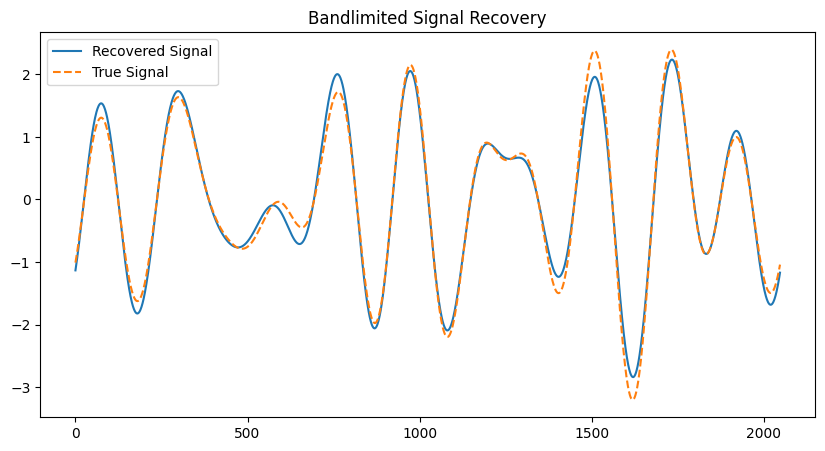

In [197]:

plt.figure(figsize=(10, 5))
plt.plot(y_est, label="Recovered Signal")
plt.plot(y, label="True Signal", linestyle="dashed")

plt.legend()
plt.title("Bandlimited Signal Recovery")
plt.show()

We see that the quality of recovery is strikingly good, however it is less accurate in amplitude around areas of change of sign of the derivative of the signal. This is likely due to the constraint on the L1 norm of our approximation , which is bounded above.